In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [4]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Converting the image to B/W
x_train[x_train < 127] = 0
x_train[x_train >= 127] = 1
x_test[x_test < 127] = 0
x_test[x_test >= 127] = 1

# For the greyscale images
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_orig_train = np.copy(y_train)
y_orig_test = np.copy(y_test)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [5]:
# Training the model
try:
    model = load_model("mnist_cnn.h5")
except ValueError:
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

OSError: Unable to open file (Unable to open file: name = 'mnist_cnn.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [4]:
def mutation_manager(data, indices):
    cols = data.shape[1]
        
    for x in indices:
        row_no = int(x/cols)
        col_no = x % cols
        
        if data[row_no, col_no] == 1:
            data[row_no, col_no] = 0
        else:
            data[row_no, col_no] = 1
    return data

In [51]:
def roulette_select(population, fitnesses, num):
    total_fitness = float(sum(fitnesses))
    rel_fitness = [f/total_fitness for f in fitnesses]
    # Generate probability intervals for each individual
    probs = [sum(rel_fitness[:i+1]) for i in range(len(rel_fitness))]
    # Draw new population
    new_population = []
    for n in range(num):
        r = np.random.random()
        for (i, individual) in enumerate(population):
            if r <= probs[i]:
                new_population.append((individual, fitnesses[i]))
                break
    return new_population

In [5]:
def crossover_manager(genome1, genome2):
    random_index_to_cut = int(np.random.random() * len(genome1))
    new1 = list(genome1[:random_index_to_cut]) + list(genome2[random_index_to_cut:])
    new2 = list(genome2[:random_index_to_cut]) + list(genome1[random_index_to_cut:])
    
    return np.asarray(new1), np.asarray(new2)

In [45]:
def genetic_op(data, required_val, mutation_rate, crossover_rate):
    # Crossover operation
    no_of_crossovers = int(data.shape[0] * crossover_rate)
    indices_to_crossover = np.random.choice(data.shape[0], no_of_crossovers, replace=False)
    data_to_be_crossover = data[indices_to_crossover]

    for x in range(0, len(indices_to_crossover) - 1, 2):
        genome1 = data_to_be_crossover[x]
        genome2 = data_to_be_crossover[x+1]
        ind1 = indices_to_crossover[x]
        ind2 = indices_to_crossover[x+1]
        new1, new2 = crossover_manager(genome1, genome2)
        data[ind1] = new1
        data[ind2] = new2
    
    # Now for the mutation operation
    no_of_mutations = int(data.shape[0] * data.shape[1] * mutation_rate)
    indices_to_mutate = np.random.choice(data.shape[0] * data.shape[1], no_of_mutations, replace=False)
    data = mutation_manager(data, indices_to_mutate)
    
    # Finally fitness
    y = data.reshape(data.shape[0], 28, 28, 1)
    r = model.predict(y)
    fitness = r[:, required_val]

    return data, fitness    

In [46]:
"""
Now to generate the fooling images, we can start from the scratch.
But doing so will take a lot of time. So we decided to start with
a population of noisy MNIST dataset
"""
# First we will split the data
num = []

for x in range(10):
    indices = np.argwhere(y_orig_train == x).reshape((-1,))
    num.append(x_train[indices])

num = np.asarray(num)

In [47]:
def add_noise(img, _):
    random_noise = np.random.randint(0, 2, (28, 28, 1)) * np.random.randint(0, 2, (28, 28, 1))
    return np.clip(img + random_noise, 0, 1)

In [2]:
# Now that the data is sorted, we take the first 20 of each of the 
# dataset and add noise to each of them.

new_num = []

for x in range(10):
    numbers = num[x][:20]
    final_image = np.apply_over_axes(add_noise, numbers, [0])
    new_num.append(final_image)

new_num = np.asarray(new_num)

NameError: name 'num' is not defined

In [1]:
# First we need to set some parameters for GA

init_crossover_rate = 0.2
init_mutation_rate = 0.05
population_size = 50
generations = 200

promotion_rate = 0.1
multiplier = int(1 / promotion_rate)

fit_num = []

# Now for each number we have to create noisy initial population.
try:
    for numb in range(10):
        mutation_rate = init_mutation_rate
        crossover_rate = init_crossover_rate
        required_val = numb
        print("Now evaluating for number", required_val)
        initial_popl = new_num[numb].reshape(
            new_num[numb].shape[0],
            new_num[numb].shape[1] * new_num[numb].shape[2]
        )
        initial_popl = np.tile(initial_popl, (population_size // new_num[numb].shape[0], 1))
        prev_popl = [[0, 0]]
        
        for gen in range(generations):
            change = False
            while not change:
                data, fitness = genetic_op(initial_popl, required_val, crossover_rate, mutation_rate)
                data_with_fitness = zip(data, fitness)
                data_with_fitness = sorted(data_with_fitness, key=lambda x: x[1], reverse=True)
    
                # Now select the promoted data for the next round
                promotion = data_with_fitness[:int(population_size * promotion_rate)]
                # promotion = roulette_select(list(data), fitness, int(population_size * promotion_rate))
                
                if prev_popl[0][1] > promotion[0][1]:
                    initial_popl = np.asarray([x[0] for x in prev_popl])
                else:
                    only_data = [x[0] for x in promotion]
                    initial_popl = np.asarray(only_data * multiplier)
                    prev_popl = promotion * multiplier
                    change = True
                    
            print("Max fitness for gen {} is {}".format(gen, promotion[0][1]))
            if promotion[0][1] > .99:
                print("Adding the image to the new array...")
                fit_num.append(promotion[0][0])
                break

except KeyboardInterrupt:
    print("GA stopped!")

Now evaluating for number 0


NameError: name 'new_num' is not defined

In [70]:
# Saving the model and the images

model.save("mnist_cnn.h5")
irregular = np.array(fit_num)
np.save("irregular_mnist.npz", irregular)


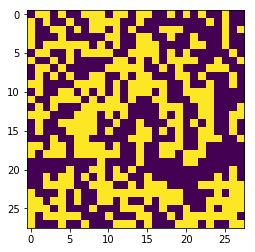

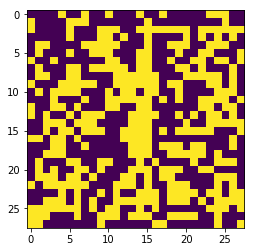

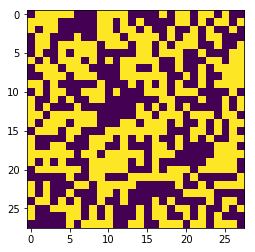

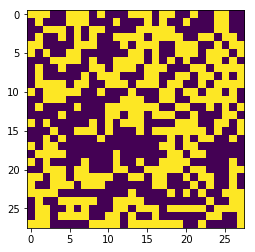

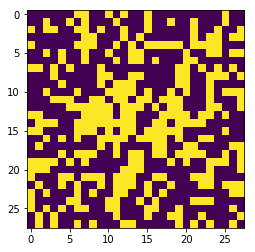

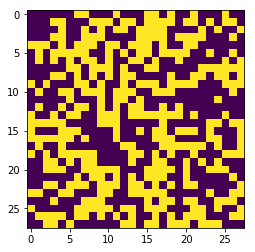

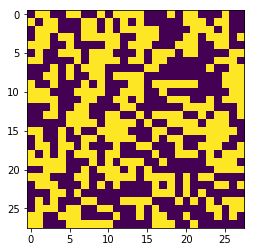

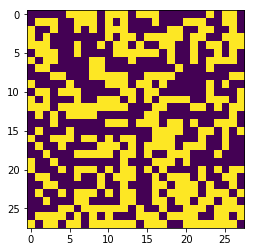

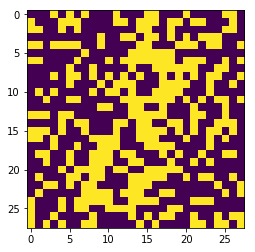

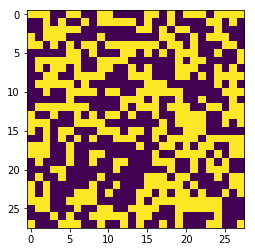

In [64]:
for x in fit_num:
    test_datapoint = x
    plt.imshow(test_datapoint.reshape(28, 28))
    plt.show()

In [65]:
# Now that numbers are generated, we'll check the accuracy again..
test = np.array(fit_num).reshape(10, 28, 28, 1)
r = model.predict(test)

for x in range(10):
    print("Accuracy for number {}: {}".format(x, r[x][x]))

Accuracy for number 0: 0.9966273903846741
Accuracy for number 1: 0.9906550049781799
Accuracy for number 2: 0.9919684529304504
Accuracy for number 3: 0.991737425327301
Accuracy for number 4: 0.9932442307472229
Accuracy for number 5: 0.9943920969963074
Accuracy for number 6: 0.9945916533470154
Accuracy for number 7: 0.9900457262992859
Accuracy for number 8: 0.9998407363891602
Accuracy for number 9: 0.9900935292243958
